In [1]:
# --- Imports
import matplotlib
import matplotlib.pyplot as plt
import torch
torch.set_default_dtype(torch.float64)
import pandas as pd
import numpy as np
from numpy import round
import scipy.stats as stats
import kan
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

#### Data Preparation

In [2]:
# --- Loading Data
fp_in = pd.read_csv("../applications_datasets/fp_inp.csv")
fp_out = pd.read_csv("../applications_datasets/fp_out.csv")

X_features = ['fuel_dens','porosity','clad_thick','pellet_OD','pellet_h','gap_thick','inlet_T','enrich','rough_fuel','rough_clad','ax_pow','clad_T','pressure']
Y_features = ['fis_gas_produced','max_fuel_centerline_temp','max_fuel_surface_temp','radial_clad_dia']
X_units = fp_in.loc[0,X_features] #type:ignore
Y_units = fp_out.loc[0,Y_features] #type:ignore
X_SCALER = StandardScaler()
Y_SCALER = StandardScaler()
X = fp_in.loc[1:,X_features].astype(float).values
Y = fp_out.loc[1:,Y_features].astype(float).values

In [3]:
# --- Test Train Split
X_TRAIN, X_TESTS, Y_TRAIN, Y_TESTS = train_test_split(X, Y, test_size=0.25)
X_TRAIN_SCALED = torch.tensor(X_SCALER.fit_transform(X_TRAIN))
X_TESTS_SCALED = torch.tensor(X_SCALER.transform(X_TESTS))
Y_TRAIN_SCALED = torch.tensor(Y_SCALER.fit_transform(Y_TRAIN))
Y_TESTS_SCALED = torch.tensor(Y_SCALER.transform(Y_TESTS))
DATASET = {'train_input':X_TRAIN_SCALED, 'test_input':X_TESTS_SCALED, 'train_label':Y_TRAIN_SCALED, 'test_label':Y_TESTS_SCALED}

In [4]:
print(f"X Features Shape:\t({X.shape[0]} Samples) x ({X.shape[1]} Features)\t\tSplit Into: ({X_TRAIN.shape[0]}/{X_TESTS.shape[0]}) Train/Test Samples")
print(f"Y Features Shape:\t({Y.shape[0]} Samples) x ({Y.shape[1]} Features)\t\tSplit Into: ({Y_TRAIN.shape[0]}/{Y_TESTS.shape[0]}) Train/Test Samples")

X Features Shape:	(399 Samples) x (13 Features)		Split Into: (299/100) Train/Test Samples
Y Features Shape:	(399 Samples) x (4 Features)		Split Into: (299/100) Train/Test Samples


#### Construction and Training

In [120]:
# --- Constructing and Initial Training
model = kan.KAN(width=[X.shape[1], 14, Y.shape[1]], grid=3, seed=43, device='cpu')

checkpoint directory created: ./model
saving model version 0.0


In [121]:
model(DATASET['train_input'])
#model.plot()

tensor([[-0.1326,  0.0668, -0.0844, -0.1042],
        [-0.1579, -0.0287,  0.0350, -0.1765],
        [-0.1950, -0.1708, -0.1938, -0.1336],
        ...,
        [-0.1216, -0.0461, -0.1224,  0.0475],
        [-0.1877,  0.1850,  0.0442, -0.1240],
        [-0.2542,  0.0044, -0.0827, -0.0286]], grad_fn=<AddBackward0>)

In [122]:
model.fit(DATASET, opt='LBFGS', steps=75, lamb=2.043e-05, lamb_entropy=5.03464, lr=1.5, reg_metric='edge_forward_sum')
print("Complete.")

| train_loss: 1.55e-02 | test_loss: 1.66e-01 | reg: 7.87e+01 | : 100%|█| 75/75 [00:28<00:00,  2.68it


saving model version 0.1
Complete.


saving model version 0.2


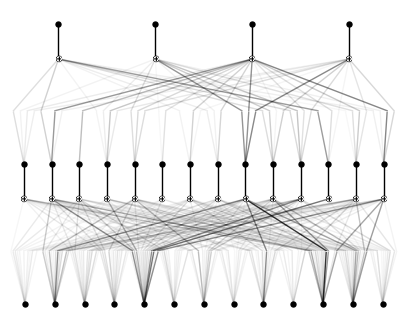

In [123]:
# --- Model Pruning and Refinement
pruned_model = model.prune(0.01, 0.01)
pruned_model.plot()

In [124]:
pruned_model = pruned_model.refine(7)

saving model version 0.3


In [125]:
pruned_model.fit(DATASET, opt='LBFGS', steps=75, lr=1.75)
print("Complete")

| train_loss: 1.69e-02 | test_loss: 1.25e-01 | reg: 6.72e+01 | : 100%|█| 75/75 [00:30<00:00,  2.44it

saving model version 0.4
Complete


In [126]:
#model.plot()

#### Visualization

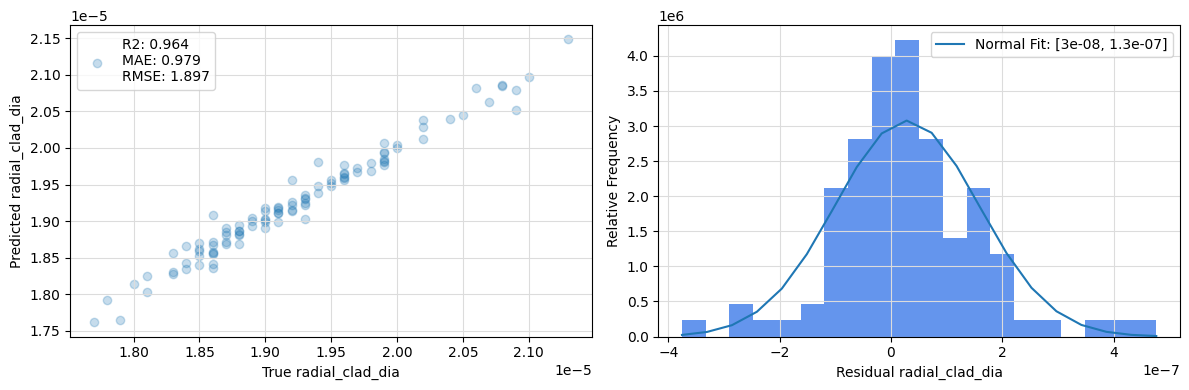

In [117]:
# --- Results - Performance
Y_PREDICTED = Y_SCALER.inverse_transform(pruned_model(X_TESTS_SCALED).detach())
Y_TRUE = Y_TESTS

i = 3

myR2 = R2(Y_TRUE, Y_PREDICTED); myMSE = MSE(Y_TRUE, Y_PREDICTED); myMAE = MAE(Y_TRUE, Y_PREDICTED)

fig, axs = plt.subplots(1,2, figsize=(12,4))

ax=axs[0]
ax.scatter(Y_TRUE[:,i], Y_PREDICTED[:,i], alpha=0.25, label=f"R2: {round(myR2,3)}\nMAE: {round(myMAE,3)}\nRMSE: {round(myMSE**0.5,3)}")
ax.set_xlabel(f"True {Y_features[i]}"); ax.set_ylabel(f"Predicted {Y_features[i]}"); ax.legend(); ax.grid(visible=True, color='gainsboro')

ax=axs[1]
residuals = Y_PREDICTED[:,i] - Y_TRUE[:,i]
pdf_fit = stats.norm.fit(residuals)
pdf_pdf = stats.norm.pdf(np.linspace(np.min(residuals),np.max(residuals),20), *pdf_fit)
ax.hist(residuals, bins=20, color='cornflowerblue', density=True)
ax.plot(np.linspace(np.min(residuals),np.max(residuals),20), pdf_pdf, label=f'Normal Fit: {[round(i,8) for i in pdf_fit]}')
ax.set_xlabel(f"Residual {Y_features[i]}"); ax.set_ylabel("Relative Frequency"); ax.grid(visible=True, color='gainsboro', label='Raw Data'); ax.legend()

fig.tight_layout()

In [96]:
# --- Symbolic Results
function_library = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','abs', '1/x', '1/x^2']
model.auto_symbolic(lib=function_library)

fixing (0,0,0) with x, r2=0.5053722164794657, c=1
fixing (0,0,1) with x, r2=0.37177486777191787, c=1
fixing (0,0,2) with x^2, r2=0.9939398351263702, c=2
fixing (0,0,3) with x, r2=0.28778734993188887, c=1
fixing (0,0,4) with x, r2=0.996389759011069, c=1
fixing (0,0,5) with x, r2=0.3032106809102497, c=1
fixing (0,0,6) with x, r2=0.9395189471096963, c=1
fixing (0,0,7) with x^2, r2=0.9821926034382885, c=2
fixing (0,0,8) with x, r2=0.6036192526212338, c=1
fixing (0,0,9) with x, r2=0.842918973626782, c=1
fixing (0,0,10) with x, r2=0.7605820509451376, c=1
fixing (0,0,11) with x, r2=0.004630853600732019, c=1
fixing (0,0,12) with x, r2=0.14356012959345157, c=1
fixing (0,0,13) with x, r2=0.7800163882659518, c=1
fixing (0,1,0) with x, r2=0.40051719224398125, c=1
fixing (0,1,1) with x^2, r2=0.9992425669861656, c=2
fixing (0,1,2) with x^2, r2=0.9986980348853975, c=2
fixing (0,1,3) with x, r2=0.8214337474802709, c=1
fixing (0,1,4) with x^2, r2=0.9980054064566237, c=2
fixing (0,1,5) with x^2, r2=0.99

In [98]:
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][3], 4) #type:ignore

0.0228*x_1 + 0.0308*x_10 + 0.0729*x_11 + 0.4037*x_12 - 0.0045*x_13 + 0.3584*x_2 + 0.0221*x_3 - 0.0369*x_4 + 0.2289*x_5 - 0.0205*x_6 - 0.0407*x_7 - 0.0168*x_8 + 0.2227*x_9 - 0.001*(0.5032 - x_1)**2 - 0.0033*(0.7023 - x_10)**2 - 0.089*(0.8712 - x_11)**2 + 0.0692*(1 - 0.22*x_2)**2 - 0.0222*(1 - 0.9753*x_4)**2 - 0.0013*(-0.9136*x_1 - 1)**2 + 0.0211*(-x_11 - 0.2257)**2 + 0.0384*(-0.7643*x_11 - 1)**2 + 0.011*(-0.6328*x_11 - 1)**2 + 0.6946*(-0.3693*x_11 - 1)**2 - 0.0078*(-0.8066*x_13 - 1)**2 + 0.0379*(-0.6205*x_13 - 1)**2 - 0.0038*(-0.6576*x_2 - 1)**2 + 0.0814*(-0.5489*x_2 - 1)**2 + 0.0132*(-0.486*x_2 - 1)**2 + 0.0033*(-x_3 - 0.453)**2 - 0.0299*(-x_3 - 0.3745)**2 + 0.009*(-0.8415*x_3 - 1)**2 + 0.0023*(-0.7296*x_3 - 1)**2 - 0.0178*(-0.725*x_3 - 1)**2 + 0.0122*(-0.7171*x_3 - 1)**2 + 0.0032*(-x_4 - 0.6812)**2 + 0.0035*(-x_4 - 0.2487)**2 + 0.0122*(-0.8252*x_4 - 1)**2 + 0.0041*(-0.7459*x_4 - 1)**2 - 0.0111*(-0.7239*x_4 - 1)**2 + 0.009*(-0.7047*x_4 - 1)**2 + 0.0046*(-0.9611*x_5 - 1)**2 - 0.1772*(-0